In [1]:
# os: use operating system dependent functions
import os

# pandas: handle the datasets in the pandas dataframe for data processing and analysis
import pandas as pd
print("pandas version: {}". format(pd.__version__))

# numpy: support for large, multi-dimensional arrays and matrices and high-level mathematical functions
import numpy as np
print("numpy version: {}". format(np.__version__))

# sklearn: machine learning and data preperation
import sklearn
from sklearn.linear_model import ElasticNet
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.decomposition import PCA
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score
print("sklearn version: {}". format(sklearn.__version__))

# hyperopt: optimize hyperparameter search
import hyperopt
from hyperopt import STATUS_OK, Trials, fmin, hp, tpe, space_eval
print("hyperopt version: {}". format(hyperopt.__version__))

# matplotlib: standard library to create visualizations
import matplotlib
import matplotlib.pyplot as plt
print("matplotlib version: {}". format(matplotlib.__version__))

# seaborn: advanced visualization library to create more advanced charts
import seaborn as sns
print("seaborn version: {}". format(sns.__version__))

# turn out warnings for better reading in the Jupyter notebbok
pd.options.mode.chained_assignment = None  # default='warn'

import warnings
warnings.filterwarnings("ignore")

pandas version: 1.3.4
numpy version: 1.21.6
sklearn version: 1.0.2
hyperopt version: 0.2.7
matplotlib version: 3.4.3
seaborn version: 0.11.2


In [2]:
# load prepared training and test dataset
df_train = pd.read_pickle('../03_dataPreprocessing/df_train_prepared.pkl')
df_test = pd.read_pickle('../03_dataPreprocessing/df_test_prepared.pkl')

In [3]:
# split the training and test dataset to the input features (x_train, x_test) and the survival class (y_train)
y_train = df_train['SalePrice']
x_train = df_train.drop(['SalePrice'], axis=1)
x_test = df_test

In [4]:
scaler_standard = StandardScaler()
x_train = scaler_standard.fit_transform(x_train)
x_test = scaler_standard.transform(x_test)

In [5]:
##Search Space
space = {
    'reducedim__n_components': hp.quniform('reducedim__n_components', 20, 200, 10),
    'regression__alpha': hp.quniform('regression__alpha', 0, 3, 0.1),
    'regression__l1_ratio': hp.quniform('regression__l1_ratio', 0, 1, 0.05)
}

In [6]:
def objective(params):
        
    pipeline = Pipeline(steps=[
        ('reducedim', PCA(
            n_components=int(params['reducedim__n_components'])
        )),
        ('regression', ElasticNet(
            alpha=params['regression__alpha'],
            l1_ratio=params['regression__l1_ratio']
        ))
    ])
    
    score = -cross_val_score(
        pipeline,
        x_train,
        y_train,
        cv=5,
        scoring="neg_mean_squared_error",
        n_jobs=-1
    ).mean()
        
    # Dictionary with information for evaluation
    return {
        'loss': score,
        'params': params,
        'status': STATUS_OK
    }

In [7]:
MAX_EVALS = 20
bayes_trials = Trials()

print('optimization starting')
# Optimize
best = fmin(
    fn=objective,
    space=space,
    algo=tpe.suggest,
    max_evals=MAX_EVALS,
    trials = bayes_trials
)
print('optimization complete')

# best_model = bayes_trials.results[np.argmin([r['loss'] for r in bayes_trials.results])]
# params = best_model['params']

optimization starting
100%|████████████████████████████████████████████████| 20/20 [00:04<00:00,  4.24trial/s, best loss: 467946398.47132146]
optimization complete


In [8]:
print(best)

{'reducedim__n_components': 110.0, 'regression__alpha': 0.4, 'regression__l1_ratio': 0.55}


Text(0, 0.5, 'loss')

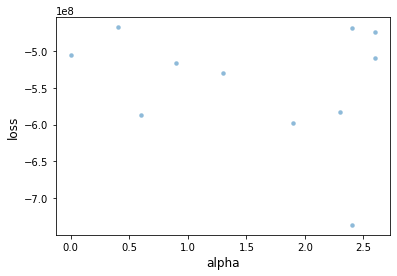

In [11]:
xs = [t['misc']['vals']['regression__alpha'] for t in bayes_trials.trials]
ys = [-t['result']['loss'] for t in bayes_trials.trials]

f, ax = plt.subplots(1)
ax.scatter(xs, ys, s=20, linewidth=0.01, alpha=0.5)
ax.set_xlabel('alpha', fontsize=12)
ax.set_ylabel('loss', fontsize=12)

Text(0, 0.5, 'loss')

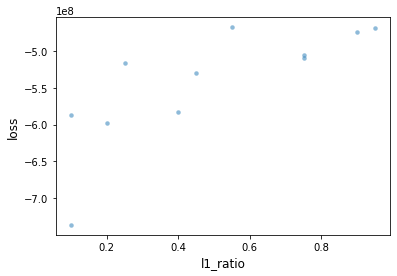

In [12]:
xs = [t['misc']['vals']['regression__l1_ratio'] for t in bayes_trials.trials]
ys = [-t['result']['loss'] for t in bayes_trials.trials]

f, ax = plt.subplots(1)
ax.scatter(xs, ys, s=20, linewidth=0.01, alpha=0.5)
ax.set_xlabel('l1_ratio', fontsize=12)
ax.set_ylabel('loss', fontsize=12)

Text(0, 0.5, 'loss')

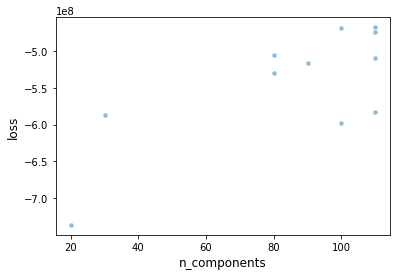

In [13]:
xs = [t['misc']['vals']['reducedim__n_components'] for t in bayes_trials.trials]
ys = [-t['result']['loss'] for t in bayes_trials.trials]

f, ax = plt.subplots(1)
ax.scatter(xs, ys, s=20, linewidth=0.01, alpha=0.5)
ax.set_xlabel('n_components', fontsize=12)
ax.set_ylabel('loss', fontsize=12)